In [ ]:
!pip install gymnasium[toy_text]

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Создаём среду CliffWalking-v1
env = gym.make("CliffWalking-v1")

# Количество состояний (4 x 12 = 48)
n_states = env.observation_space.n
print("Число состояний:", n_states)

# 0: вверх, 1: вправо, 2: вниз, 3: влево
def safe_policy(state):
    row, col = np.unravel_index(state, (4, 12))

    if row == 3 and col == 0:
        return 0  # вверх

    if row == 2 and col < 11:
        return 1  # вправо

    if row == 2 and col == 11:
        return 2  # вниз

    return 1

Число состояний: 48


In [ ]:
def generate_episode(env, policy, gamma=1.0, max_steps=1000):
    #Генерирует один эпизод, следуя policy и возвращает список пар (state, reward)
    states_rewards = []

    state, info = env.reset()
    done = False
    step = 0

    while not done and step < max_steps:
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        states_rewards.append((state, reward))
        state = next_state

        done = terminated or truncated or (reward <= -100)
        step += 1

    return states_rewards

In [ ]:
ep = generate_episode(env, safe_policy)
print("Длина эпизода:", len(ep))
print(ep)

Длина эпизода: 13
[(36, -1), (24, -1), (25, -1), (26, -1), (27, -1), (28, -1), (29, -1), (30, -1), (31, -1), (32, -1), (33, -1), (34, -1), (35, -1)]


In [ ]:
def mc_prediction(env, policy, n_states, n_episodes=500, gamma=1.0, alpha=0.1):
    #Оценка V(s) методом Монте-Карло (first-visit, инкрементальная форма)
    V = np.zeros(n_states)
    rmse_history = []

    V_prev = V.copy()

    for episode_idx in range(n_episodes):
        episode = generate_episode(env, policy, gamma=gamma)

        visited_states = set()
        G = 0.0

        for t in reversed(range(len(episode))):
            s_t, r_t1 = episode[t]
            G = gamma * G + r_t1

            if s_t not in visited_states:
                visited_states.add(s_t)
                V[s_t] += alpha * (G - V[s_t])

        rmse = np.sqrt(np.mean((V - V_prev) ** 2))
        rmse_history.append(rmse)
        V_prev = V.copy()

    return V, np.array(rmse_history)

In [ ]:
def td0_prediction(env, policy, n_states, n_episodes=500, gamma=1.0, alpha=0.1):
    #Оценка V(s) методом TD(0)
    V = np.zeros(n_states)
    rmse_history = []

    V_prev = V.copy()

    for episode_idx in range(n_episodes):
        state, info = env.reset()
        done = False
        step = 0

        while not done and step < 1000:
            action = policy(state)
            next_state, reward, terminated, truncated, info = env.step(action)

            td_target = reward + gamma * V[next_state]
            td_error = td_target - V[state]
            V[state] += alpha * td_error

            state = next_state
            done = terminated or truncated or (reward <= -100)
            step += 1

        rmse = np.sqrt(np.mean((V - V_prev) ** 2))
        rmse_history.append(rmse)
        V_prev = V.copy()

    return V, np.array(rmse_history)

In [ ]:
V_mc_01, rmse_mc_01 = mc_prediction(env, safe_policy, n_states, n_episodes, gamma, alpha=0.1)
V_td_01, rmse_td_01 = td0_prediction(env, safe_policy, n_states, n_episodes, gamma, alpha=0.1)

V_mc_05, rmse_mc_05 = mc_prediction(env, safe_policy, n_states, n_episodes, gamma, alpha=0.5)
V_td_05, rmse_td_05 = td0_prediction(env, safe_policy, n_states, n_episodes, gamma, alpha=0.5)

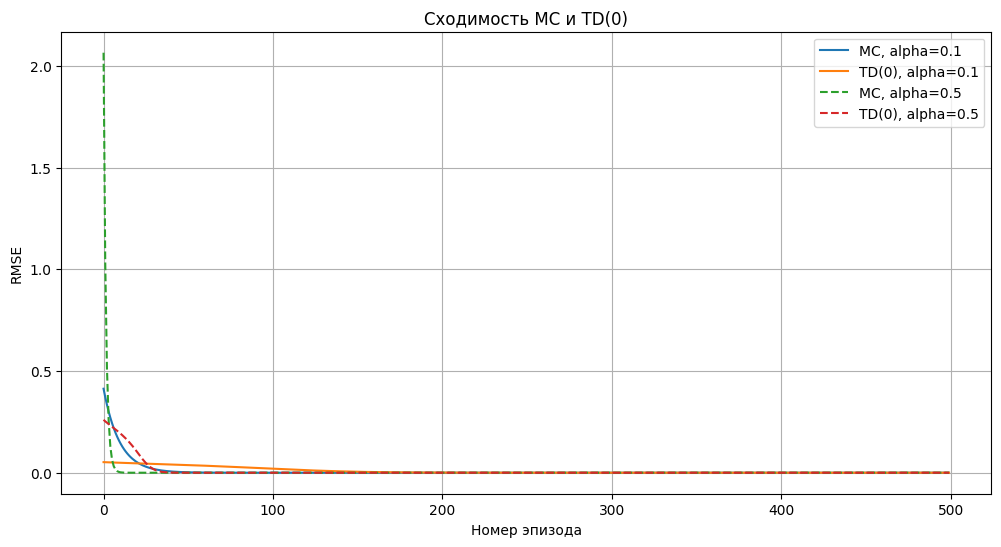

In [ ]:
*-plt.figure(figsize=(12, 6))

plt.plot(rmse_mc_01, label="MC, alpha=0.1")
plt.plot(rmse_td_01, label="TD(0), alpha=0.1")

plt.plot(rmse_mc_05, label="MC, alpha=0.5", linestyle="--")
plt.plot(rmse_td_05, label="TD(0), alpha=0.5", linestyle="--")

plt.xlabel("Номер эпизода")
plt.ylabel("RMSE")
plt.title("Сходимость MC и TD(0)")
plt.legend()
plt.grid(True)
plt.show()

RMSE показывает, насколько сильно в среднем меняется функция ценности V(s) между соседними эпизодами. В начале обучения RMSE большая, так как алгоритм активно обновляет оценки. По мере обучения RMSE уменьшается и стремится к нулю, что означает сходимость. По графику видно, что TD(0) сходится быстрее, чем MC, что соответствует теории: TD имеет меньшую дисперсию за счёт бутстрэппинга, но является смещённой оценкой.

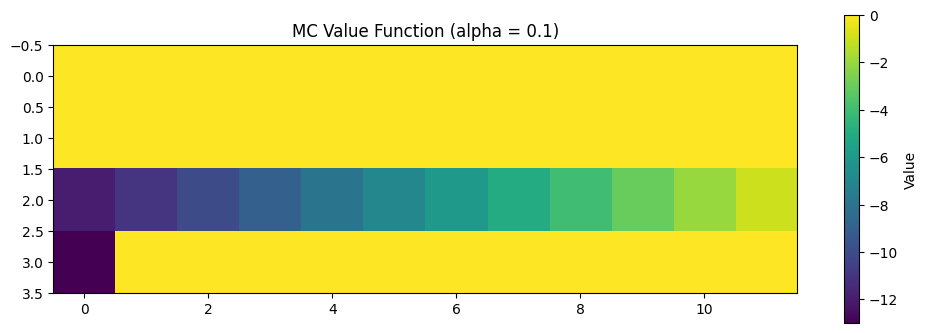

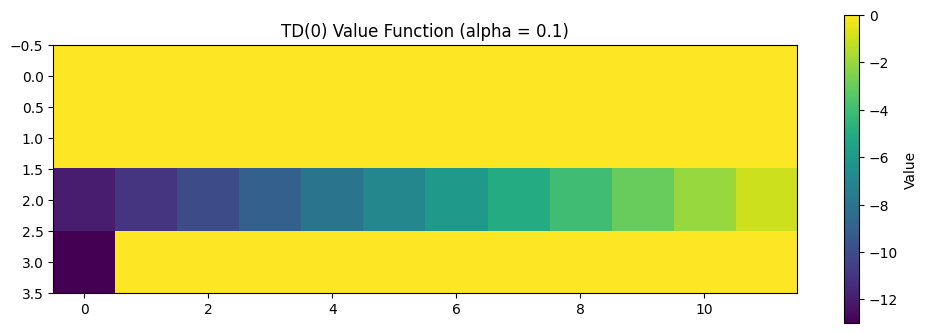

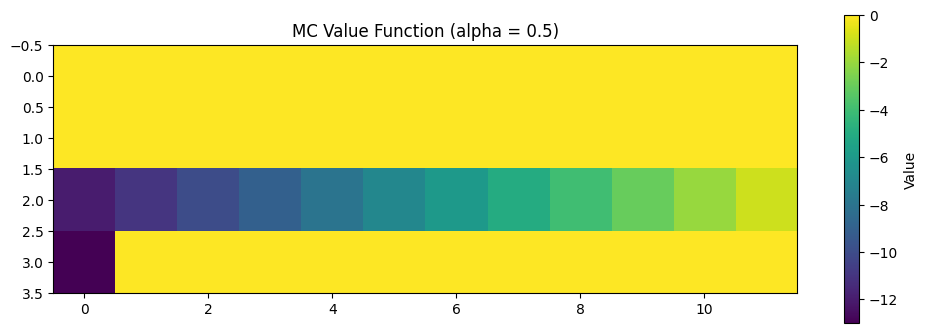

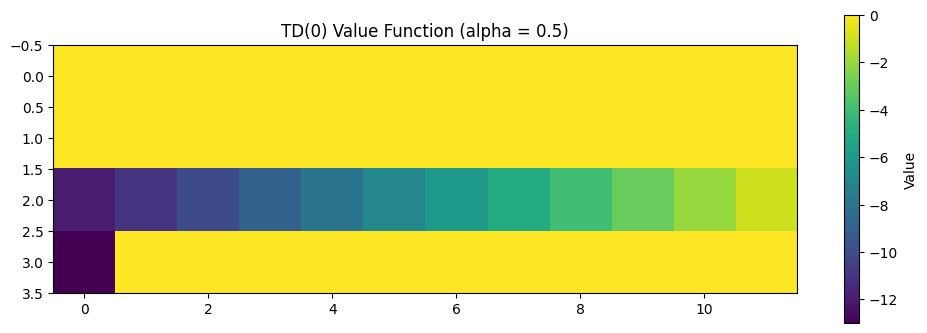

In [ ]:
plot_value_function(V_mc_01, title="MC Value Function (alpha = 0.1)")
plot_value_function(V_td_01, title="TD(0) Value Function (alpha = 0.1)")

plot_value_function(V_mc_05, title="MC Value Function (alpha = 0.5)")
plot_value_function(V_td_05, title="TD(0) Value Function (alpha = 0.5)")